In [205]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from scipy.special import inv_boxcox
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Скачайте текст произведения «Война и мир».   
### Очистите его, оставив только русские буквы и символы пробела.

In [57]:
text = []
file = 'tom_'

for i in range(4):
    with open(f'{file}{i + 1}.txt', 'r') as f:
        text.append(f.read().lower())

text = re.sub('[^а-я ]','', ''.join(text))

### Постройте матрицу переходных вероятностей.

In [59]:
russian = ''.join(set(text))
POS = {l: i for i, l in enumerate(russian)}

In [61]:
probabilities = np.zeros((len(russian), len(russian)))

In [63]:
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1

In [65]:
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

In [67]:
df = pd.DataFrame(probabilities, index=(c for c in russian), columns=(c for c in russian))

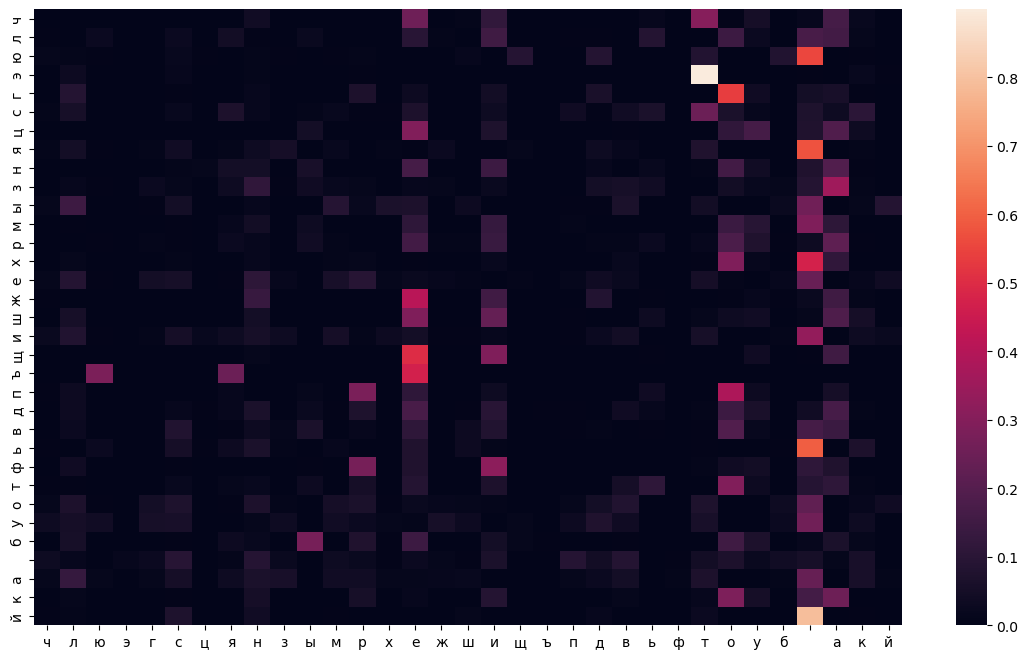

In [69]:
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

### Посчитайте вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р».

In [91]:
matrix = np.matmul(np.matmul(df, df), np.matmul(df, df))

In [93]:
prior = 1. / len(russian)

In [109]:
start = POS['п']
end = POS['р']
proba = prior * probabilities[start, end]

In [111]:
proba

0.008421371763565222

### Используя матрицу переходных вероятностей, сгенерируйте слово, начинающееся с буквы «Б» длиной восемь символов.

In [122]:
s = []
start = 'б'
s.append(start)
length = 7
for i in range(length):
    index = POS[s[i]]
    next_char = np.random.choice(list(russian), p=probabilities[index])
    s.append(next_char)

print (''.join(s))

бни прав


### Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM.

In [125]:
df_ts = pd.read_csv('monthly-sales-of-company-x-jan-6.csv', sep=',')
df_ts.head()

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36


<Axes: >

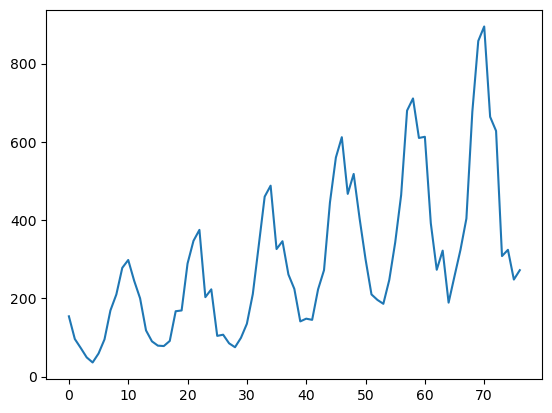

In [127]:
df_ts.Count.plot()

In [135]:
series = df_ts['Count']
# уберем изменение дисперсии при помощи преобразования Бокса-Кокса
series_diff = boxcox(series, 0)

#  уберем наличие тренда, дифференцированием.
series_diff = series_diff[1:] - series_diff[:-1]

In [137]:
def train_test_split(ser, test_val=0.3):

    count = int(len(ser) * (1.0 - test_val))
    return ser[:count], ser[count:]

train, test = train_test_split(series_diff, 0.3)
train_r = train.reshape(-1, 1)
test_r = test.reshape(-1, 1)

In [179]:
#  поиск оптимального количества скрытых состояний
indx = []
score = []

for i in range(1, 21):
    mdl = GaussianHMM(n_components=i, n_iter=1000)
    mdl.fit(train_r)
    scor = mdl.score(train_r)
    indx.append(i)
    score.append(scor)

# запишем результат в таблицу
res = pd.DataFrame({"index": indx, "score": score}).set_index("index")
opt = res["score"].idxmax()

Fitting a model with 62 free scalar parameters with only 53 data points will result in a degenerate solution.
Model is not converging.  Current: 10.747204969473813 is not greater than 10.756879534387798. Delta is -0.00967456491398444
Fitting a model with 79 free scalar parameters with only 53 data points will result in a degenerate solution.
Model is not converging.  Current: 10.203945532932128 is not greater than 10.20902457620979. Delta is -0.00507904327766262
Fitting a model with 98 free scalar parameters with only 53 data points will result in a degenerate solution.
Fitting a model with 119 free scalar parameters with only 53 data points will result in a degenerate solution.
Fitting a model with 142 free scalar parameters with only 53 data points will result in a degenerate solution.
Fitting a model with 167 free scalar parameters with only 53 data points will result in a degenerate solution.
Fitting a model with 194 free scalar parameters with only 53 data points will result in a 

Fitting a model with 359 free scalar parameters with only 53 data points will result in a degenerate solution.


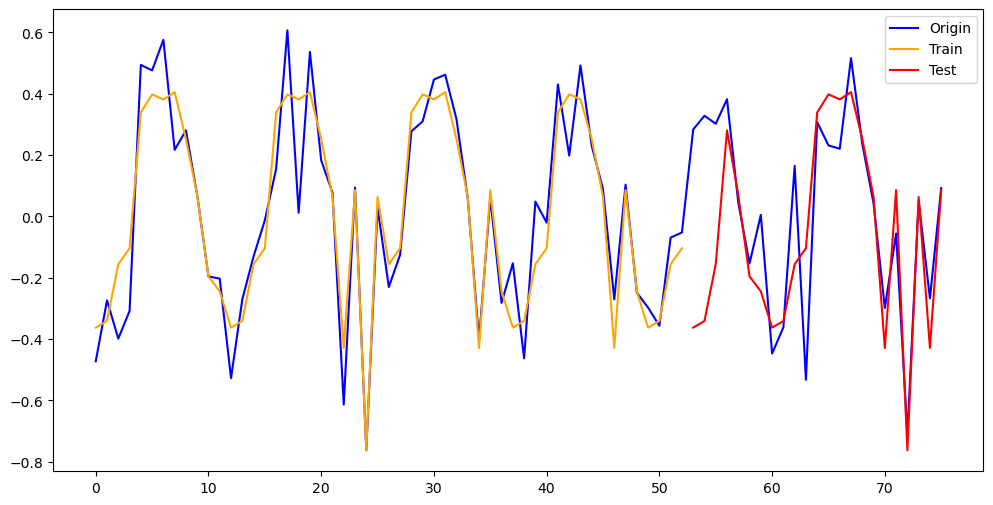

In [183]:
def get_averag (mdl, ser):

    labels = mdl.predict(ser)
    avg = np.zeros_like(ser)

    for i in range(mdl.n_components):
        avg[labels == i] = mdl.means_[i]
    return avg

mdl_hmm = GaussianHMM(n_components=opt, n_iter=1000)
mdl_hmm.fit(train_r)

avg_train = get_averag (mdl_hmm, train_r)
avg_test  = get_averag(mdl_hmm, test_r)

plt.figure(figsize=(12, 6))
plt.plot(series_diff, color='blue')

plt.plot(avg_train, color='orange')

plt.plot([i for i in range(len(train), len(series_diff))], avg_test, color = 'red')

plt.legend(["Origin", "Train", "Test"])
plt.show()